In [1]:
import Random, Logging
using Gen, Plots, Distributions

# Disable logging, because @animate is verbose otherwise
Logging.disable_logging(Logging.Info);

In [2]:
function f(y::Vector{<:Real}, beta::Real, gamma::Real, N::Real)
    f_SIR = zeros(3)
    f_SIR[1] = - beta/N*y[1]*y[2]
    f_SIR[2] = beta/N*y[1]*y[2] - gamma*y[2]
    f_SIR[3] = gamma*y[2]
    return f_SIR
end

f (generic function with 1 method)

In [3]:
@gen function runge_kutta(y0::Vector{<:Real}, T_max::Int, steps::Int)
    beta ~normal(3,1)
    gamma ~normal(3,1) 

    progress = Array{Float64}(undef, steps, 3)
    progress[1,:] = y0
    N = 1000
    
    h = T_max / steps
    n = steps-1

    for i = 1:n
        k1 = f(progress[i,:], beta, gamma, N)
        k2 = f(progress[i,:] + k1 * h / 2.0, beta, gamma, N)
        k3 = f(progress[i,:] + k2 * h / 2.0, beta, gamma, N)
        k4 = f(progress[i,:] + k3 * h, beta, gamma, N)
        progress[i+1,:] = progress[i,:] + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    end

    return progress
end;
    

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{<:Real}, Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##runge_kutta#292", Bool[0, 0, 0], false)

In [4]:
@gen function runge_kutta_data(y0::Vector{<:Real}, T_max::Int, steps::Int)
    beta = pop!(rand(Normal(6, 1), 1))
    gamma = pop!(rand(Normal(5, 1), 1))

    progress = Array{Float64}(undef, steps, 3)
    print(first(progress))
    progress[1,:] = y0
    # print(progress)
    N = 1000
    
    h = T_max / steps
    n = steps-1

    for i = 1:n
        k1 = f(progress[i,:], beta, gamma, N)
        k2 = f(progress[i,:] + k1 * h / 2.0, beta, gamma, N)
        k3 = f(progress[i,:] + k2 * h / 2.0, beta, gamma, N)
        k4 = f(progress[i,:] + k3 * h, beta, gamma, N)
        progress[i+1,:] = progress[i,:] + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    end

    return progress
end;


In [5]:
function make_the_constraints(ys::Matrix{Float64})
    constraints = Gen.choicemap()
    for i=1:size(ys, 1)
        for j=1:size(ys, 2)
            constraints[:data => i => j => :y] = ys[i, j]
        end
    end
    constraints
end;

In [6]:
data = runge_kutta_data([9900.0, 100.0, 0.0], 100, 100)
observations_kuch = make_the_constraints(data);

0.0

In [7]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

In [11]:
traces = [first(Gen.importance_resampling(runge_kutta, ([9900,100,0],30,30), observations_kuch, 2000)) for i in 1:3000]

3000-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{<:Real}, Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##runge_kutta#292", Bool[0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:beta => Gen.ChoiceOrCallRecord{Float64}(2.7322785395229325, -0.9547759234046597, NaN, true), :gamma => Gen.ChoiceOrCallRecord{Float64}(2.5899620601939164, -1.0030040892448815, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -1.957780012649541, 0.0, ([9900, 100, 0], 30, 30), [9900.0 100.0 0.0; 2.4622714472363938e7 -2.4519880040707503e7 -92834.43165643603; … ; NaN NaN NaN; NaN NaN NaN])
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{<:Real}, Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing, 

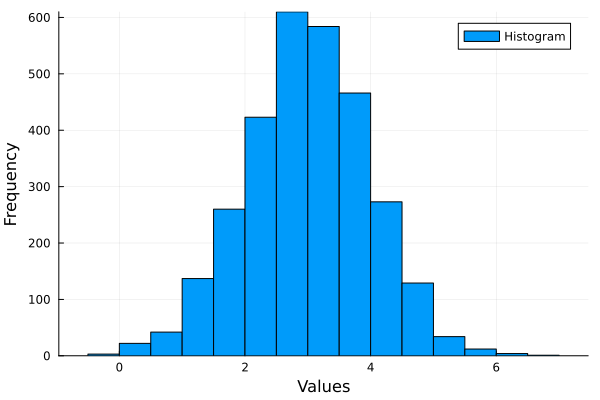

In [12]:
beta = Float64[]
gamma = Float64[]
for i in traces
    choices = get_choices(i)
    gamma_value = choices[:gamma]
    push!(gamma, gamma_value)
    beta_value = choices[:beta]
    push!(beta, beta_value)
    end

Plots.histogram(beta, bins=30, xlabel="Values", ylabel="Frequency", label="Histogram")

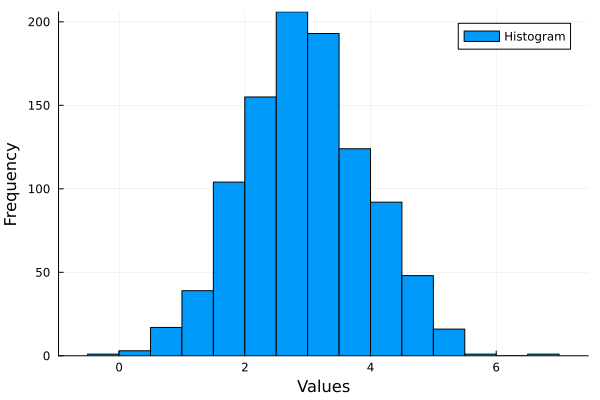

In [10]:
Plots.histogram(gamma, bins=30, xlabel="Values", ylabel="Frequency", label="Histogram")